# Алгоритмы сокращения пространства поиска на графе регулярной декомпозиции за счет симметрии и смежных техник (JPS и его модификации).

_Федор Мамаев, Прохор Архипов, 22Б09_

TODO: написать какую-то очень умную воду

<center><img src="./img/1.png"/></center>

In [1]:
import random
import math
import traceback
import time
import sys
from heapq import heappop, heappush
from pathlib import Path
from textwrap import dedent
from typing import *

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from PIL import Image, ImageDraw

%matplotlib inline

rand = random.Random(192837)

## 1. Представление карты

In [2]:
class Cell:
    def __init__(self, i: int, j: int):
        self._i = i
        self._j = j
    
    @property
    def i(self):
        return self._i
    
    @property
    def j(self):
        return self._j
    
    def __eq__(self, other):
        return isinstance(other, Cell) and (self._i, self._j) == (other._i, other._j)
    
    def __hash__(self) -> int:
        return hash((self._i, self._j))
    
    def __str__(self):
        return f'({self._i}, {self._j})'

In [3]:
class Direction:
    def __init__(self, di: int, dj: int):
        self._di = di
        self._dj = dj
    
    @property
    def di(self):
        return self._di
    
    @property
    def dj(self):
        return self._dj
    
    @property
    def delta(self):
        return (self._di, self._dj)
    
    @property
    def is_diagonal(self):
        return self._di != 0 and self._dj != 0
    
    def reversed(self):
        return Direction(-self._di, -self._dj)
    
    def __eq__(self, other):
        return isinstance(other, Direction) and self.delta == other.delta
    
    def __hash__(self):
        return hash(self.delta)

Direction.NONE = Direction(0, 0)
Direction.DOWN = Direction(1, 0)
Direction.RIGHT = Direction(0, 1)
Direction.UP = Direction(-1, 0)
Direction.LEFT = Direction(0, -1)
Direction.DIAG_DR = Direction(1, 1)
Direction.DIAG_UR = Direction(-1, 1)
Direction.DIAG_DL = Direction(1, -1)
Direction.DIAG_UL = Direction(-1, -1)
Direction.ALL_DIRECTIONS = [
    Direction.DOWN,
    Direction.RIGHT,
    Direction.UP,
    Direction.LEFT,
    Direction.DIAG_DR,
    Direction.DIAG_UR,
    Direction.DIAG_DL,
    Direction.DIAG_UL,
]

def direction_from_to(a: Cell, b: Cell):
    return Direction(b.i - a.i, b.j - a.j)

def step(cell: Cell, d: Direction):
    return Cell(cell.i + d.di, cell.j + d.dj)

In [4]:
class Map:
    def __init__(self, cells: npt.NDArray):
        self._width = cells.shape[1]
        self._height = cells.shape[0]
        self._cells = cells

    def in_bounds(self, cell: Cell) -> bool:
        return 0 <= cell.j < self._width and 0 <= cell.i < self._height

    def traversable(self, cell: Cell) -> bool:
        return self.in_bounds(cell) and not self._cells[cell.i, cell.j]

    def get_neighbours(self, cell: Cell) -> List[Cell]:
        neighbours = []
        
        i = cell.i
        j = cell.j

        # срезание углов разрешено
        for d in Direction.ALL_DIRECTIONS:
            next = step(cell, d)
            if self.traversable(next):
                neighbours.append(next)

        return neighbours

    @property
    def size(self) -> Tuple[int, int]:
        return (self._height, self._width)
    
    @property
    def height(self) -> int:
        return self._height
    
    @property
    def width(self) -> int:
        return self._width

In [5]:
def convert_string_to_cells(cell_str: str) -> npt.NDArray:
    lines = cell_str.replace(" ", "").split("\n")

    cells = np.array(
        [[1 if char == "#" else 0 for char in line] for line in lines if line],
        dtype=np.int8,
    )
    return cells

In [6]:
def compute_cost(a: Cell, b: Cell) -> Union[int, float]:
    if abs(a.i - b.i) + abs(a.j - b.j) == 1:  # Cardinal move
        return 1
    elif abs(a.i - b.i) == 1 and abs(a.j - b.j) == 1:
        return math.sqrt(2)
    else:
        raise ValueError("Trying to compute the cost of a non-supported move! ONLY cardinal and diagonal moves are supported.")

## 2. Вершина поиска

In [7]:
class Node:
    def __init__(
        self,
        cell: Cell,
        g: Union[float, int] = 0,
        h: Union[float, int] = 0,
        f: Optional[Union[float, int]] = None,
        parent: "Node" = None,
    ):
        self.cell = cell
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent

    @property
    def i(self):
        return self.cell.i
    
    @property
    def j(self):
        return self.cell.j

    def __eq__(self, other):
        return self.cell == other.cell

    def __hash__(self):
        return hash(self.cell) ^ 0x19283746

    def __lt__(self, other):
        return (self.f < other.f) or (self.f == other.f and self.h < other.h)  # лучший tie-break

## 3. Дерево поиска

In [8]:
class SearchTreePQD:
    def __init__(self):
        self._open = []
        self._closed = {}
        self._enc_open_duplicates = 0

    def __len__(self) -> int:
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        while not self.open_is_empty() and self.was_expanded(self._open[0]):
            self._enc_open_duplicates += 1
            heappop(self._open)
        if self.open_is_empty():
            return None
        return heappop(self._open)
        
    def add_to_closed(self, item: Node):
        self._closed[item.cell] = item

    def was_expanded(self, item: Node) -> bool:
        return item.cell in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_duplicates(self):
        return self._enc_open_duplicates

## 4. Валидация результатов

In [9]:
def make_path(goal: Optional[Node]) -> Tuple[Optional[List[Node]], Union[float, int]]:
    if goal is None:
        return None, 0

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

## 5. Чтение заданий из файла

In [10]:
class Task:
    # TODO: пока optimal_dist читается из файла, но в дальнейшем
    # нужно придумать, как оценивать его с помощью стандартного A*,
    # не делая это два раза
    def __init__(self, bucket: int, map: Map, start: Cell, goal: Cell, optimal_dist: float):
        self.bucket = bucket
        self.map = map
        self.start = start
        self.goal = goal
        self.optimal_dist = optimal_dist

In [11]:
def read_map_from_file(filename: str) -> Map:
    with open(filename, 'r') as file:
        file.readline()                           # type octile
        height = int(file.readline().strip().split()[1])  # height XX
        width  = int(file.readline().strip().split()[1])  # width YY
        file.readline()                           # map

        map = np.ndarray(shape=(height, width), dtype=np.dtypes.BoolDType)
        for i in range(height):
            row = file.readline()
            for j in range(width):
                map[i, j] = row[j] in ['@', 'O', 'T']
        
        return Map(map)

In [12]:
map_storage: Dict[str, Map] = {}

def get_map(filename: str) -> Map:
    if filename not in map_storage:
        map_storage[filename] = read_map_from_file(f'./tasks/maps/{filename}')
    return map_storage[filename]

In [13]:
def read_scenario_from_file(filename: str) -> List[Task]:
    tasks = []
    with open(filename, 'r') as file:
        file.readline()  # version x.x

        for line in file.readlines():
            bucket_s, map_name, height_s, width_s, start_j_s, start_i_s, goal_j_s, goal_i_s, optimal_dist_s = line.strip().split('\t')
            map = get_map(map_name)
            tasks.append(Task(
                int(bucket_s),
                map,
                Cell(int(start_i_s), int(start_j_s)),
                Cell(int(goal_i_s), int(goal_j_s)),
                float(optimal_dist_s)
            ))
    return tasks

## 6. Параметры алгоритма A*

In [14]:
# типы

HeuristicFunc = Callable[[Cell, Cell], float]
NeighboursFunc = Callable[[Node, Map, Cell, HeuristicFunc], List[Node]]  # curr node, map, goal, heuristic -> neighbours

In [15]:
def heuristic_octile(a: Cell, b: Cell):
    dr = max(abs(a.i - b.i), abs(a.j - b.j))
    dl = min(abs(a.i - b.i), abs(a.j - b.j))
    return (dr - dl) + dl * math.sqrt(2)

In [16]:
def weighted_heuristic(heuristic_func: HeuristicFunc, weight: float) -> HeuristicFunc:
    return lambda a, b: heuristic_func(a, b) * weight

In [17]:
def neighbours_all(curr_node: Node, map: Map, goal: Cell, heuristic_func: HeuristicFunc):
    return [
        Node(
            cell=next_cell,
            g=curr_node.g + compute_cost(curr_node.cell, next_cell),
            h=heuristic_func(next_cell, goal),
            parent=curr_node
        )
        for next_cell in map.get_neighbours(curr_node.cell)
    ]

### 6.1. Функция поиска точек прыжка для алгоритма JPS

In [18]:
# можем ли мы повернуть в соответствии с Canonical Ordering
def can_turn(curr_d: Direction, next_d: Direction):
    if curr_d == next_d:
        return True
    if curr_d.is_diagonal and \
       (next_d.delta == (curr_d.di, 0) or \
        next_d.delta == (0, curr_d.dj)):
        return True
    return False

# направление первого шага от a к b согласно canonical ordering
def canonical_direction_from_to(a: Cell, b: Cell):
    d = direction_from_to(a, b)
    d = Direction((d.di // abs(d.di) if d.di != 0 else 0),
                  (d.dj // abs(d.dj) if d.dj != 0 else 0))
    return d

# см. статью
def get_forced_neighbours(curr_cell: Cell, map: Map, d: Direction):
    parent_cell = step(curr_cell, d.reversed())
    return [
        next_cell
        for next_cell in map.get_neighbours(curr_cell)
        if canonical_direction_from_to(parent_cell, next_cell) != d and \
           not map.traversable(step(parent_cell, canonical_direction_from_to(parent_cell, next_cell)))
    ]

jps_jump_memo: Dict[Tuple[Map, Cell, Direction], Optional[Cell]] = {}
def jps_jump(curr_cell: Cell, map: Map, d: Direction, goal: Cell, heuristic_func: HeuristicFunc, bound: Optional[int]) -> Optional[Node]:
    global jps_jump_memo
    
    memo_id = (map, curr_cell, d)
    if memo_id in jps_jump_memo:
        return jps_jump_memo[memo_id]
    
    next_cell = step(curr_cell, d)

    if not map.traversable(next_cell):
        jps_jump_memo[memo_id] = None
        return None

    if next_cell == goal or \
       (bound is not None and bound == 0) or \
       len(get_forced_neighbours(next_cell, map, d)) != 0:
       jps_jump_memo[memo_id] = next_cell
       return next_cell
    
    if d.is_diagonal:
        for d_proj in (Direction(d.di, 0), Direction(0, d.dj)):
            if jps_jump(next_cell, map, d_proj, goal, heuristic_func, (bound - 1) if bound is not None else None) is not None:
                jps_jump_memo[memo_id] = next_cell
                return next_cell

    jps_jump_memo[memo_id] = jps_jump(next_cell, map, d, goal, heuristic_func, (bound - 1) if bound is not None else None)
    return jps_jump_memo[memo_id]

def clear_jps_jump_memo():
    global jps_jump_memo
    jps_jump_memo = {}

In [19]:
# направления для раскрытия в соответствии с full canonical ordering
def canonical_directions_for_expansion(curr_node: Node, map: Map):
    if curr_node.parent is None:
        return Direction.ALL_DIRECTIONS
    
    d = direction_from_to(curr_node.parent.cell, curr_node.cell)
    if len(get_forced_neighbours(curr_node.cell, map, d)) != 0:
        return Direction.ALL_DIRECTIONS
    if d.is_diagonal:
        return [d, Direction(d.di, 0), Direction(0, d.dj)]
    return [d]

def jps_generate_neighbours(curr_node: Node, map: Map, goal: Cell, heuristic_func: HeuristicFunc, bound: Optional[int]) -> List[Node]:
    jump_points = list(filter(lambda it: it is not None, [
        jps_jump(curr_node, map, d, goal, heuristic_func, bound)
        for d in canonical_directions_for_expansion(curr_node, map)
    ]))
    neighbours = []

    for jump_point in jump_points:
        node = curr_node
        while node.cell != jump_point:
            d = canonical_direction_from_to(node.cell, jump_point)
            next_cell = step(node.cell, d)
            next_node = Node(
                cell=next_cell,
                g=node.g + compute_cost(node.cell, next_cell),
                h=heuristic_func(next_cell, goal),
                parent=node
            )
            node = next_node
        neighbours.append(node)
    
    return neighbours

def neighbours_bounded_jps(bound: int) -> NeighboursFunc:
    return lambda curr_node, map, goal, heuristic_func: jps_generate_neighbours(
        curr_node, map, goal, heuristic_func, bound
    )

neighbours_canonical_astar = neighbours_bounded_jps(0)
neighbours_jps = neighbours_bounded_jps(None)

## 7. Алгоритм A*

In [20]:
def astar_search(
    task_map: Map,
    start: Cell,
    goal: Cell,
    heuristic_func: HeuristicFunc,
    neighbours_func: NeighboursFunc,
    search_tree: Type[SearchTreePQD],
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    # нужно очистить мемоизацию JPS, чтобы трезво оценить время работы алгоритма
    # (хотя при нахождении большого количества путей на одной карте его можно
    # было бы сократить таким образом)
    clear_jps_jump_memo()
    
    # Returns: found or not, final node, steps, tree size
    ast = search_tree()
    steps = 0

    start_node = Node(cell=start, g=0, h=heuristic_func(start, goal))
    ast.add_to_open(start_node)

    while not ast.open_is_empty():
        curr_node: Node = ast.get_best_node_from_open()
        if curr_node is None:
            break
        curr_cell: Cell = curr_node.cell
        ast.add_to_closed(curr_node)

        if curr_cell == goal:
            return True, curr_node, steps, len(ast), ast.opened, ast.expanded

        steps += 1
        for next_node in neighbours_func(curr_node, task_map, goal, heuristic_func):
            if not ast.was_expanded(next_node):
                ast.add_to_open(next_node)

    return False, None, steps, len(ast), None, ast.expanded

In [21]:
AstarAlgorithm = Callable[[Map, Cell, Cell], Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]]

standard_astar  = lambda map, start, goal: astar_search(map, start, goal, heuristic_octile, neighbours_all, SearchTreePQD)
canonical_astar = lambda map, start, goal: astar_search(map, start, goal, heuristic_octile, neighbours_canonical_astar, SearchTreePQD)
jps             = lambda map, start, goal: astar_search(map, start, goal, heuristic_octile, neighbours_jps, SearchTreePQD)

def weighted_astar(weight: float):
    return lambda map, start, goal: astar_search(
        map, start, goal, weighted_heuristic(heuristic_octile, weight), neighbours_all, SearchTreePQD
    )
def weighted_jps(weight: float):
    return lambda map, start, goal: astar_search(
        map, start, goal, weighted_heuristic(heuristic_octile, weight), neighbours_jps, SearchTreePQD
    )
def bounded_jps(bound: int):
    return lambda map, start, goal: astar_search(
        map, start, goal, heuristic_octile, neighbours_bounded_jps(bound), SearchTreePQD
    )
def weighted_bounded_jps(weight: float, bound: int):
    return lambda map, start, goal: astar_search(
        map, start, goal, weighted_heuristic(heuristic_octile, weight), neighbours_bounded_jps(bound), SearchTreePQD
    )

In [22]:
optimal_algorithm = ('A*', standard_astar)
all_algorithms = [
    optimal_algorithm,
    ('Canonical A*', canonical_astar),
    ('BJPS (bound = 1)', bounded_jps(1)),
    ('BJPS (bound = 4)', bounded_jps(4)),
    ('BJPS (bound = 16)', bounded_jps(16)),
    ('BJPS (bound = 64)', bounded_jps(64)),
    # ('BJPS (bound = 256)', bounded_jps(256)),
    ('JPS', jps),
    # ('WA* (W = 1.2)', weighted_astar(1.2)),
    ('WA* (W = 2)', weighted_astar(2)),
    # ('WA* (W = 5)', weighted_astar(5)),
    ('Weighted JPS (W = 2)', weighted_jps(2)),
    # ('Weighted BJPS (W = 1.2, bound = 64)', weighted_bounded_jps(1.2, 64)),
    # ('Weighted BJPS (W = 2, bound = 64)', weighted_bounded_jps(2, 64))
]

## 8. Визуализация работы алгоритмов

In [23]:
def draw_rectangle(draw, node, scale, color):
    """Draws a rectangle on the grid, given the node and the desired color."""
    draw.rectangle(
        (
            node.j * scale,
            node.i * scale,
            (node.j + 1) * scale - 1,
            (node.i + 1) * scale - 1,
        ),
        fill=color,
        width=0,
    )


def draw(
    grid_map: Map,
    start: Optional[Node] = None,
    goal: Optional[Node] = None,
    path: Optional[Iterable[Node]] = None,
    nodes_discovered: Optional[Iterable[Node]] = None,
    nodes_expanded: Optional[Iterable[Node]] = None,
):
    scale = 5
    height, width = grid_map.size
    im = Image.new("RGB", (width * scale, height * scale), color="white")
    draw = ImageDraw.Draw(im)

    # Draw blocked cells
    for i in range(height):
        for j in range(width):
            if not grid_map.traversable(Cell(i, j)):
                draw.rectangle(
                    (j * scale, i * scale, (j + 1) * scale - 1, (i + 1) * scale - 1),
                    fill=(70, 80, 80),
                )

    node_colors = [
        (nodes_discovered, (213, 219, 219)),
        (nodes_expanded, (131, 145, 146))
    ]

    for nodes, color in node_colors:
        if nodes is not None:
            for node in nodes:
                draw_rectangle(draw, node, scale, color)

    if path is not None:
        for step in path:
            color = (52, 152, 219) if grid_map.traversable(step.cell) else (230, 126, 34)
            draw_rectangle(draw, step, scale, color)

    if start is not None and grid_map.traversable(start.cell):
        draw_rectangle(draw, start, scale, (40, 180, 99))

    if goal is not None and grid_map.traversable(goal.cell):
        draw_rectangle(draw, goal, scale, (231, 76, 60))

    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

In [24]:
def simple_test(search_function: AstarAlgorithm):
    task_map = get_map('Berlin_1_256.map')
    start = Node(Cell(223, 236))
    goal = Node(Cell(3, 16))

    try:
        (
            found,
            final_node,
            steps,
            tree_size,
            *other_results
        ) = search_function(task_map, start.cell, goal.cell)

        print(f'Start: {start.cell}')
        print(f'Goal:  {goal.cell}')

        if found:
            path, path_length = make_path(final_node)
            draw(task_map, start, goal, path, *other_results)
            print(
                f"Path found! Length: {path_length}. Search tree size: {tree_size}. Number of steps: {steps}"
            )
        else:
            print("Path not found!")
            draw(task_map, start, goal)
        return

    except Exception as e:
        print(f"Execution error: {e}")
        traceback.print_exc()


=== A*
Start: (223, 236)
Goal:  (3, 16)


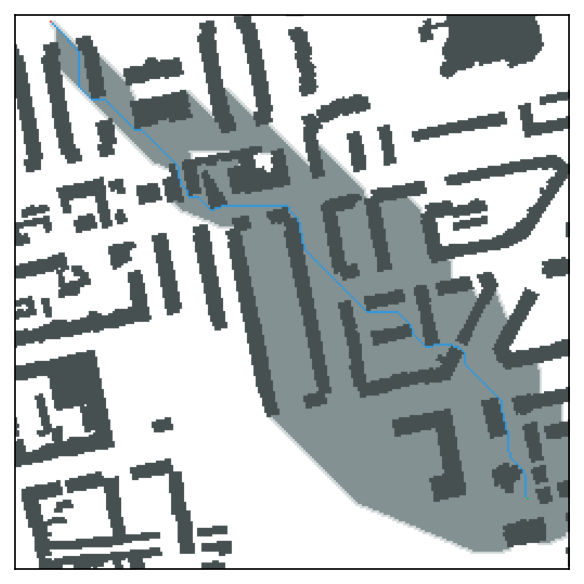

Path found! Length: 359.889393668846. Search tree size: 19299. Number of steps: 15305
CPU times: user 1.38 s, sys: 285 ms, total: 1.67 s
Wall time: 1.48 s

=== Canonical A*
Start: (223, 236)
Goal:  (3, 16)


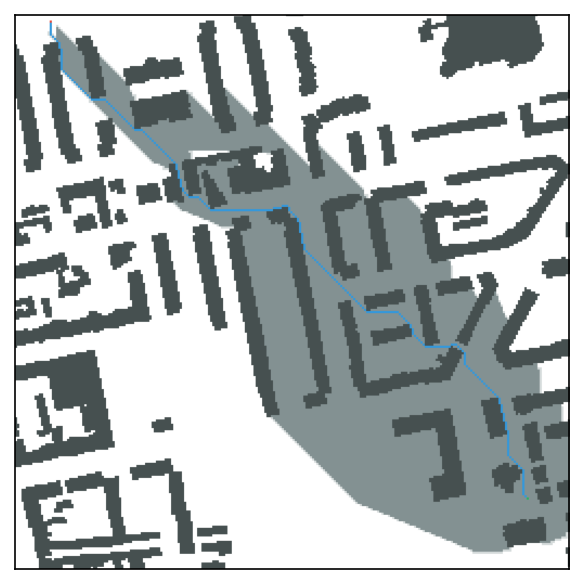

Path found! Length: 359.889393668846. Search tree size: 15662. Number of steps: 15311
CPU times: user 1.32 s, sys: 195 ms, total: 1.51 s
Wall time: 1.28 s

=== BJPS (bound = 1)
Start: (223, 236)
Goal:  (3, 16)


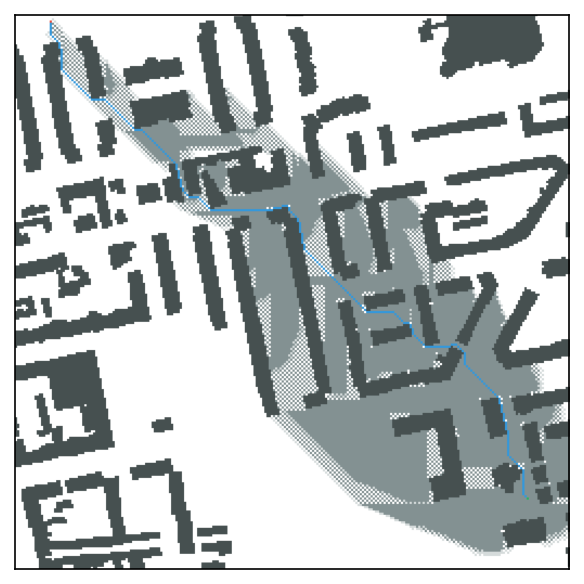

Path found! Length: 359.889393668846. Search tree size: 13832. Number of steps: 13148
CPU times: user 2.07 s, sys: 193 ms, total: 2.26 s
Wall time: 2.07 s

=== BJPS (bound = 4)
Start: (223, 236)
Goal:  (3, 16)


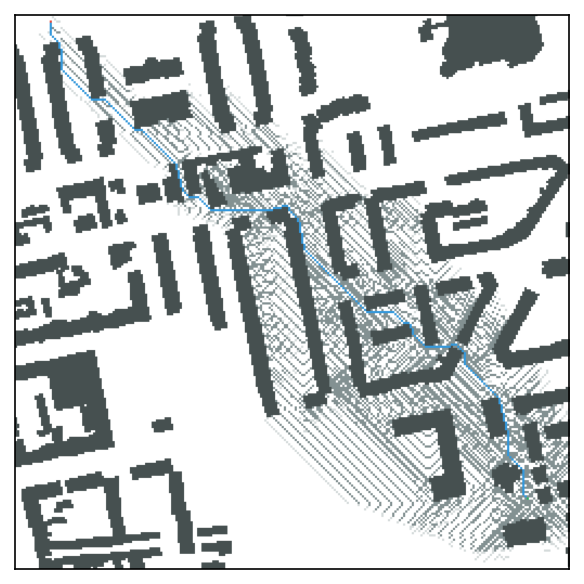

Path found! Length: 359.889393668846. Search tree size: 6975. Number of steps: 6112
CPU times: user 2.18 s, sys: 208 ms, total: 2.39 s
Wall time: 2.2 s

=== BJPS (bound = 16)
Start: (223, 236)
Goal:  (3, 16)


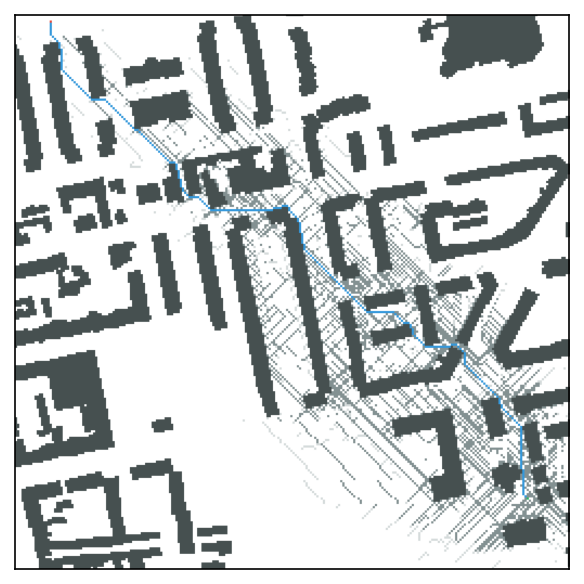

Path found! Length: 359.88939366884597. Search tree size: 5256. Number of steps: 3874
CPU times: user 2.98 s, sys: 199 ms, total: 3.18 s
Wall time: 2.95 s

=== BJPS (bound = 64)
Start: (223, 236)
Goal:  (3, 16)


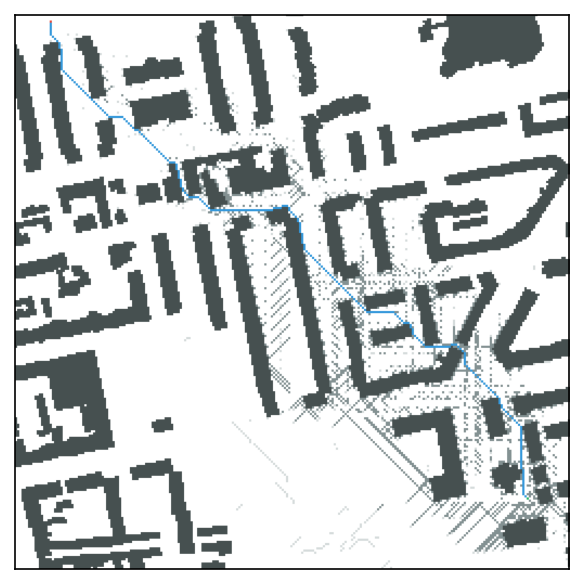

Path found! Length: 359.88939366884597. Search tree size: 3334. Number of steps: 2256
CPU times: user 3.62 s, sys: 184 ms, total: 3.81 s
Wall time: 3.69 s

=== JPS
Start: (223, 236)
Goal:  (3, 16)


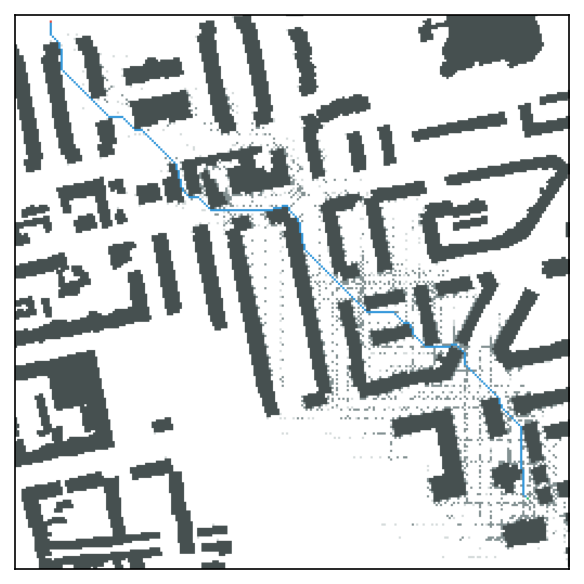

Path found! Length: 359.88939366884597. Search tree size: 2352. Number of steps: 1749
CPU times: user 3.62 s, sys: 269 ms, total: 3.89 s
Wall time: 3.66 s

=== WA* (W = 2)
Start: (223, 236)
Goal:  (3, 16)


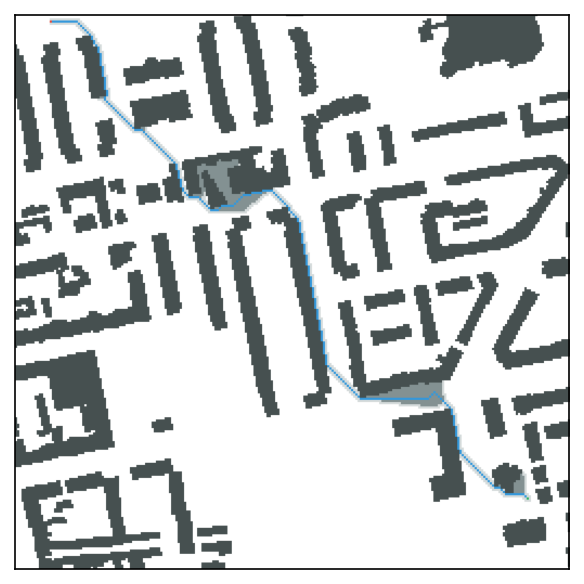

Path found! Length: 382.23253941935354. Search tree size: 2435. Number of steps: 837
CPU times: user 378 ms, sys: 206 ms, total: 585 ms
Wall time: 363 ms

=== Weighted JPS (W = 2)
Start: (223, 236)
Goal:  (3, 16)


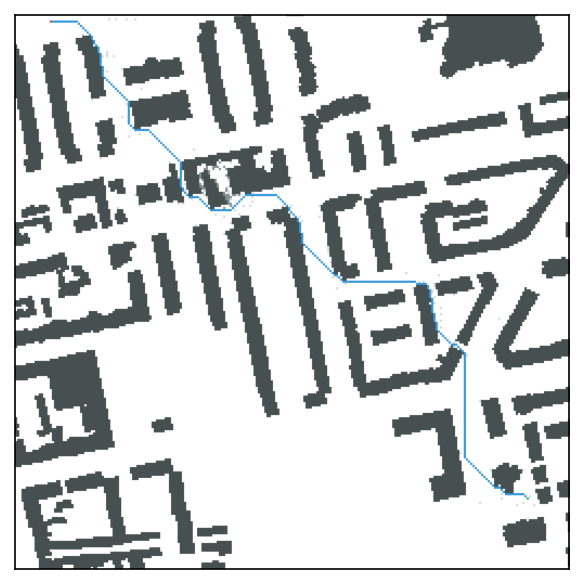

Path found! Length: 380.77669529663785. Search tree size: 249. Number of steps: 123
CPU times: user 814 ms, sys: 192 ms, total: 1.01 s
Wall time: 791 ms


In [25]:
for alg_name, algorithm in all_algorithms:
    print()
    print('=========')
    print(f'=== {alg_name}')
    print('=========')
    %time simple_test(algorithm)

## 9. Давайте проведём бенчмаркинг

TODO: написать ещё какую-нибудь умную воду (вообще её надо написать везде, где только можно)

Все карты скачаны с https://movingai.com/benchmarks/grids.html

<center><img src="./img/2.png"/></center>

### 9.0. Полезные функции

In [26]:
def run_on_task(
    task: Task, algorithm: AstarAlgorithm
) -> Tuple[bool, Optional[List[Node]], float, int, int, float]:
    # Returns: found o/n, result path, path length, steps, tree size, time
    start_time = time.time()
    found, final_node, steps, tree_size, _, _ = algorithm(
        task.map,
        task.start,
        task.goal
    )
    end_time = time.time()
    result_path, path_length = make_path(final_node)
    return found, result_path, path_length, steps, tree_size, end_time - start_time

In [27]:
def run_on_tasks(
    tasks: List[Task],
    # algorithms[0] считается оптимальным по длине пути алгоритмом
    algorithms: List[Tuple[str, AstarAlgorithm]],
    show_info: bool = True,
    progressbar_length: int = 50
) -> Dict[str, Tuple[np.array, np.array, np.array, np.array]]:
    summary = {
        alg_name: ([], [], [], [], []) for alg_name, _ in algorithms
    }

    tasks_num = len(tasks)
    tasks_completed = 0
    progress_units_completed = 0
    if show_info:
        print(' ' + '_' * progressbar_length + ' ')
        print('[', end='')

    for task in tasks:
        optimal_path_length = -1
        for alg_name, algorithm in algorithms:
            _, _, path_length, steps, tree_size, time_spent = run_on_task(task, algorithm)
            if optimal_path_length == -1:
                optimality = 1.0
                if path_length == 0:
                    path_length = 0.00001
                optimal_path_length = path_length
                task.optimal_dist = path_length
            else:
                optimality = path_length / optimal_path_length
            summary[alg_name][0].append(optimality)
            summary[alg_name][1].append(path_length)
            summary[alg_name][2].append(tree_size)
            summary[alg_name][3].append(steps)
            summary[alg_name][4].append(time_spent)

        tasks_completed += 1
        if show_info:
            while tasks_completed >= int(tasks_num / progressbar_length * (progress_units_completed + 1)) and progress_units_completed < progressbar_length:
                progress_units_completed += 1
                print('|', end='')
                sys.stdout.flush()
    
    if show_info:
        print(']')
    
    return {
        alg_name: tuple(map(lambda lst: np.array(lst), summary[alg_name]))
        for alg_name in summary.keys()
    }

In [28]:
def plot_summary(summary: Dict[str, Tuple[np.array, np.array, np.array, np.array, np.array]], bar_color: str):
    algorithm_names = list(summary.keys())

    optimality_data = [
        np.array(summary[alg_name][0]) * 100
        for alg_name in algorithm_names
    ]
    length_data = [
        summary[alg_name][1]
        for alg_name in algorithm_names
    ]
    tree_size_data = [
        summary[alg_name][2]
        for alg_name in algorithm_names
    ]
    steps_data = [
        summary[alg_name][3]
        for alg_name in algorithm_names
    ]
    time_data = [
        summary[alg_name][4]
        for alg_name in algorithm_names
    ]
    optimality_avg = [
        float(np.mean(summary[alg_name][0])) * 100
        for alg_name in algorithm_names
    ]
    length_avg = [
        float(np.mean(summary[alg_name][1]))
        for alg_name in algorithm_names
    ]
    tree_size_avg = [
        float(np.mean(summary[alg_name][2]))
        for alg_name in algorithm_names
    ]
    steps_avg = [
        float(np.mean(summary[alg_name][3]))
        for alg_name in algorithm_names
    ]
    time_avg = [
        float(np.mean(summary[alg_name][4]))
        for alg_name in algorithm_names
    ]

    print('===== SUMMARY =====')
    print('=== Average cost overhead: ===')
    print('\n'.join(['%s: %d%%' % it for it in zip(algorithm_names, map(int, optimality_avg))]))
    print('=== Average path length: ===')
    print('\n'.join(['%s: %.6f' % it for it in zip(algorithm_names, length_avg)]))
    print('=== Average search tree size: ===')
    print('\n'.join(['%s: %d' % it for it in zip(algorithm_names, tree_size_avg)]))
    print('=== Average expansions: ===')
    print('\n'.join(['%s: %d' % it for it in zip(algorithm_names, steps_avg)]))
    print('=== Average time usage: ===')
    print('\n'.join(['%s: %.4f s' % it for it in zip(algorithm_names, time_avg)]))

    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 36))
    ((ax_opbw, ax_opa), (ax_lnbw, ax_lna), (ax_tsbw, ax_tsa), (ax_exbw, ax_exa), (ax_tmbw, ax_tma)) = axs
    ax_opbw.set_title('Cost Overhead (%)')
    ax_lnbw.set_title('Path Length')
    ax_tsbw.set_title('Search Tree Size')
    ax_exbw.set_title('Expansions')
    ax_tmbw.set_title('Time Spent (s)')
    ax_opa.set_title('Average Cost Overhead (%)')
    ax_lna.set_title('Average Path Length')
    ax_tsa.set_title('Average Search Tree Size')
    ax_exa.set_title('Average Expansions')
    ax_tma.set_title('Average Time (s)')

    boxplots = [
        ax_opbw.boxplot(optimality_data, tick_labels=algorithm_names, patch_artist=True),
        ax_lnbw.boxplot(length_data,     tick_labels=algorithm_names, patch_artist=True),
        ax_tsbw.boxplot(tree_size_data,  tick_labels=algorithm_names, patch_artist=True),
        ax_exbw.boxplot(steps_data,      tick_labels=algorithm_names, patch_artist=True),
        ax_tmbw.boxplot(time_data,       tick_labels=algorithm_names, patch_artist=True)
    ]
    
    for boxplot in boxplots:
        for patch in boxplot['boxes']:
            patch.set_facecolor(bar_color)
    
    barplots = [
        ax_opa.bar(algorithm_names, optimality_avg, color=bar_color),
        ax_lna.bar(algorithm_names, length_avg,     color=bar_color),
        ax_tsa.bar(algorithm_names, tree_size_avg,  color=bar_color),
        ax_exa.bar(algorithm_names, steps_avg,      color=bar_color),
        ax_tma.bar(algorithm_names, time_avg,       color=bar_color)
    ]

    for ax in axs[:, 0]:
        ax.set_xticks(range(1, 1 + len(algorithm_names)))
        ax.set_xticklabels(algorithm_names, rotation=90)
    for ax in axs[:, 1]:
        ax.set_xticks(range(len(algorithm_names)))
        ax.set_xticklabels(algorithm_names, rotation=90)

    fig.tight_layout()
    plt.show()

In [29]:
# Task difficulty (defined by the length of the optimal path)
EASY_MAX   = 100
MEDIUM_MAX = 500
HARD_MAX   = 1500
# Maximum number of tasks per difficulty level
EASY_NUM = 200
MEDIUM_NUM = 100
HARD_NUM = 30
BRUTAL_NUM = 10

In [30]:
def test_on_scenarios(scenario_filenames: List[str]):
    tasks: List[Task] = []

    for scen_fn in scenario_filenames:
        tasks += read_scenario_from_file(f'tasks/scenarios/{scen_fn}')
    
    tasks_easy = []
    tasks_medm = []
    tasks_hard = []
    tasks_shrd = []

    for task in tasks:
        if task.optimal_dist < EASY_MAX:
            tasks_easy.append(task)
        elif task.optimal_dist < MEDIUM_MAX:
            tasks_medm.append(task)
        elif task.optimal_dist < HARD_MAX:
            tasks_hard.append(task)
        else:
            tasks_shrd.append(task)

    while len(tasks_easy) > EASY_NUM:
        del tasks_easy[rand.randint(0, len(tasks_easy) - 1)]
    while len(tasks_medm) > MEDIUM_NUM:
        del tasks_medm[rand.randint(0, len(tasks_medm) - 1)]
    while len(tasks_hard) > HARD_NUM:
        del tasks_hard[rand.randint(0, len(tasks_hard) - 1)]
    while len(tasks_shrd) > BRUTAL_NUM:
        del tasks_shrd[rand.randint(0, len(tasks_shrd) - 1)]

    if len(tasks_easy) > 0:
        print(f'Running tests on Easy tasks, {len(tasks_easy)} tasks total...')
        plot_summary(run_on_tasks(tasks_easy, all_algorithms), 'Green')
    else:
        print(f'No Easy tasks found in the scenarios')
    if len(tasks_medm) > 0:
        print(f'Running tests on Medium tasks, {len(tasks_medm)} tasks total...')
        plot_summary(run_on_tasks(tasks_medm, all_algorithms), 'Orange')
    else:
        print(f'No Medium tasks found in the scenarios')
    if len(tasks_hard) > 0:
        print(f'Running tests on Hard tasks, {len(tasks_hard)} tasks total...')
        plot_summary(run_on_tasks(tasks_hard, all_algorithms), 'Red')
    else:
        print(f'No Hard tasks found in the scenarios')
    if len(tasks_shrd) > 0:
        print(f'Running tests on Brutal tasks, {len(tasks_shrd)} tasks total...')
        plot_summary(run_on_tasks(tasks_shrd, all_algorithms), '#66023c')
    else:
        print(f'No Brutal tasks found in the scenarios')

### 9.1. Карты городов 256x256

Running tests on Easy tasks, 200 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average cost overhead: ===
A*: 100%
Canonical A*: 100%
BJPS (bound = 1): 100%
BJPS (bound = 4): 100%
BJPS (bound = 16): 100%
BJPS (bound = 64): 100%
JPS: 100%
WA* (W = 2): 101%
Weighted JPS (W = 2): 101%
=== Average path length: ===
A*: 49.353357
Canonical A*: 49.353357
BJPS (bound = 1): 49.353357
BJPS (bound = 4): 49.353357
BJPS (bound = 16): 49.353357
BJPS (bound = 64): 49.353357
JPS: 49.353357
WA* (W = 2): 50.264210
Weighted JPS (W = 2): 50.690686
=== Average search tree size: ===
A*: 562
Canonical A*: 308
BJPS (bound = 1): 260
BJPS (bound = 4): 149
BJPS (bound = 16): 91
BJPS (bound = 64): 46
JPS: 31
WA* (W = 2): 345
Weighted JPS (W = 2): 26
=== Average expansions: ===
A*: 196
Canonical A*: 260
BJPS (bound = 1): 208
BJPS (bound = 4): 97
BJPS (bound = 16): 45
BJPS (bound = 64): 20
JPS: 14
WA* (W = 2): 94
Weig

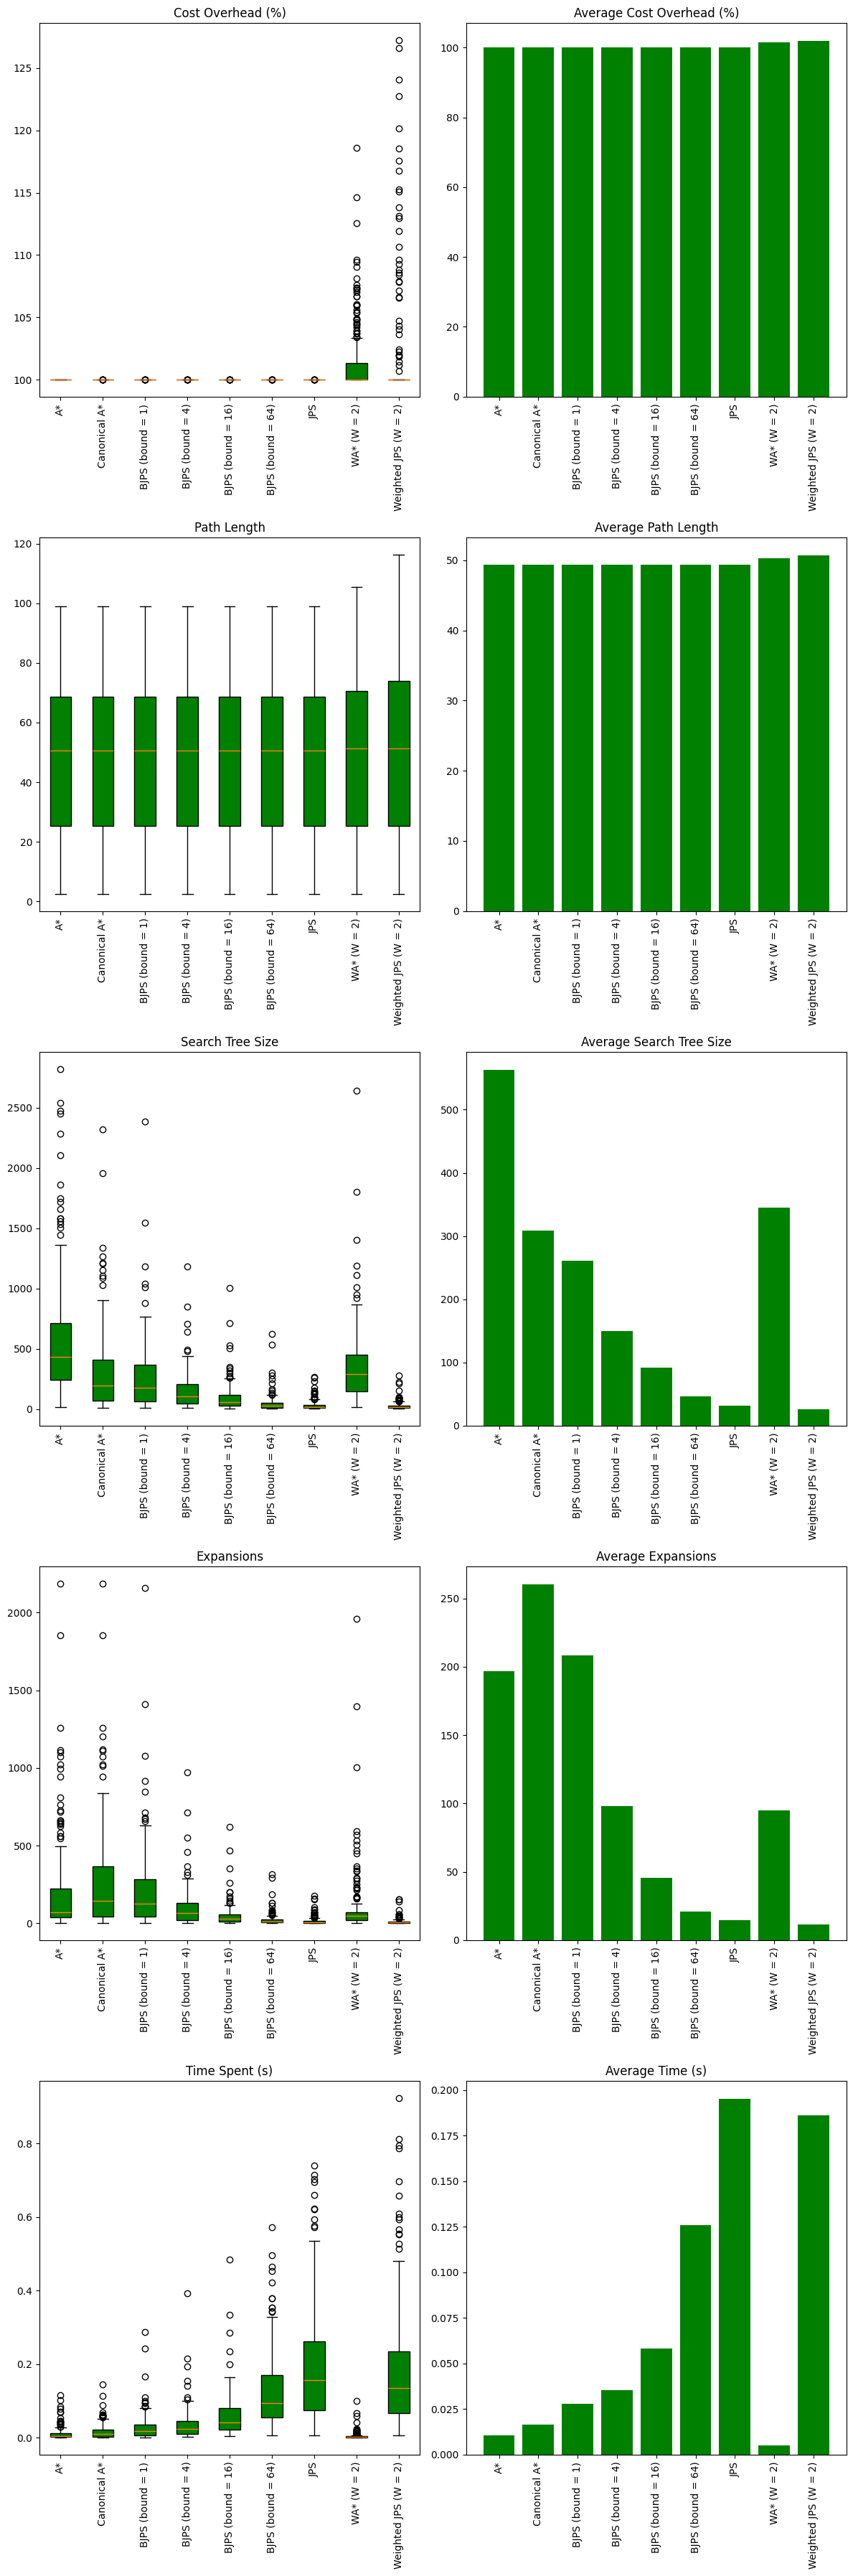

Running tests on Medium tasks, 100 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average cost overhead: ===
A*: 100%
Canonical A*: 100%
BJPS (bound = 1): 100%
BJPS (bound = 4): 100%
BJPS (bound = 16): 100%
BJPS (bound = 64): 100%
JPS: 100%
WA* (W = 2): 105%
Weighted JPS (W = 2): 106%
=== Average path length: ===
A*: 234.376218
Canonical A*: 234.376218
BJPS (bound = 1): 234.376218
BJPS (bound = 4): 234.376218
BJPS (bound = 16): 234.376218
BJPS (bound = 64): 234.376218
JPS: 234.376218
WA* (W = 2): 247.470135
Weighted JPS (W = 2): 250.627534
=== Average search tree size: ===
A*: 11427
Canonical A*: 7200
BJPS (bound = 1): 6224
BJPS (bound = 4): 3028
BJPS (bound = 16): 2125
BJPS (bound = 64): 1290
JPS: 835
WA* (W = 2): 2424
Weighted JPS (W = 2): 219
=== Average expansions: ===
A*: 6956
Canonical A*: 6984
BJPS (bound = 1): 5876
BJPS (bound = 4): 2605
BJPS (bound = 16): 1541
BJPS (bound = 64): 8

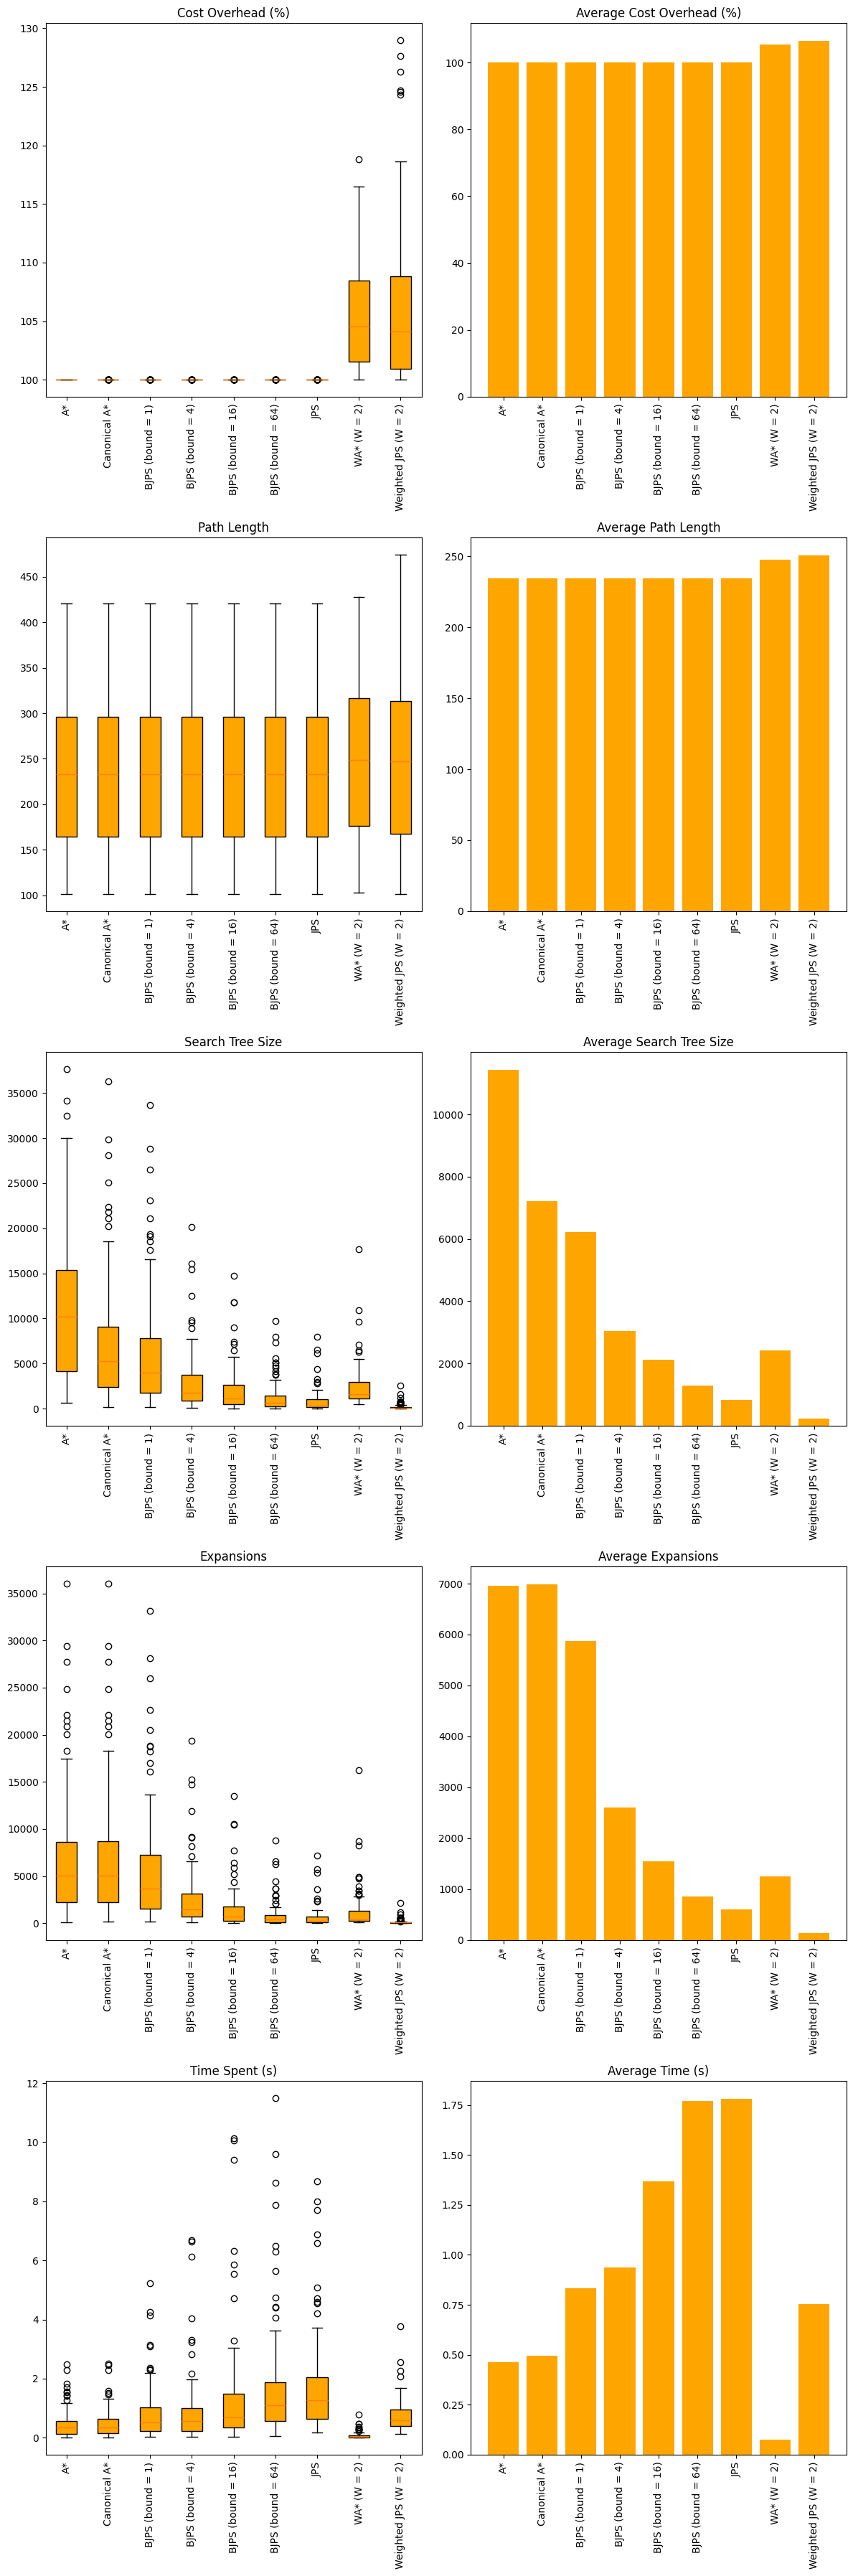

No Hard tasks found in the scenarios
No Brutal tasks found in the scenarios


In [31]:
rand = random.Random(192837)

city256_scenarios = [
    'Berlin_0_256.map.scen',
    'Berlin_1_256.map.scen',
    'London_2_256.map.scen',
    'Milan_1_256.map.scen',
    'Moscow_0_256.map.scen',
    'Paris_1_256.map.scen',
    'Shanghai_0_256.map.scen',
    'Sydney_2_256.map.scen'
]

test_on_scenarios(city256_scenarios)

### 9.2. Карты городов 1024x1024

In [32]:
rand = random.Random(192838)

city1024_scenarios = [
    'Berlin_1_1024.map.scen',
    'Milan_1_1024.map.scen',
    'Moscow_0_1024.map.scen',
    'Shanghai_0_1024.map.scen'
]

test_on_scenarios(city1024_scenarios)

Running tests on Easy tasks, 200 tasks total...
 __________________________________________________ 
[|||||||||||||||||

KeyboardInterrupt: 

### 9.3. Полностью случайные карты

In [ ]:
rand = random.Random(192839)

random_scenarios = [
    'random512-10-0.map.scen',
    'random512-15-4.map.scen',
    'random512-20-6.map.scen',
    'random512-25-5.map.scen',
    'random512-30-9.map.scen',
    'random512-35-7.map.scen',
    'random512-40-2.map.scen'
]

test_on_scenarios(random_scenarios)

### 9.4. Карты-лабиринты

Running tests on Easy tasks, 200 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average cost overhead: ===
A*: 100%
Canonical A*: 100%
BJPS (bound = 1): 100%
BJPS (bound = 4): 100%
BJPS (bound = 16): 100%
BJPS (bound = 64): 100%
JPS: 100%
WA* (W = 2): 101%
Weighted JPS (W = 2): 100%
=== Average path length: ===
A*: 51.179757
Canonical A*: 51.179757
BJPS (bound = 1): 51.179757
BJPS (bound = 4): 51.179757
BJPS (bound = 16): 51.179757
BJPS (bound = 64): 51.179757
JPS: 51.179757
WA* (W = 2): 51.859067
Weighted JPS (W = 2): 51.329341
=== Average search tree size: ===
A*: 609
Canonical A*: 423
BJPS (bound = 1): 306
BJPS (bound = 4): 154
BJPS (bound = 16): 73
BJPS (bound = 64): 33
JPS: 26
WA* (W = 2): 438
Weighted JPS (W = 2): 22
=== Average expansions: ===
A*: 353
Canonical A*: 384
BJPS (bound = 1): 263
BJPS (bound = 4): 116
BJPS (bound = 16): 45
BJPS (bound = 64): 23
JPS: 20
WA* (W = 2): 228
We

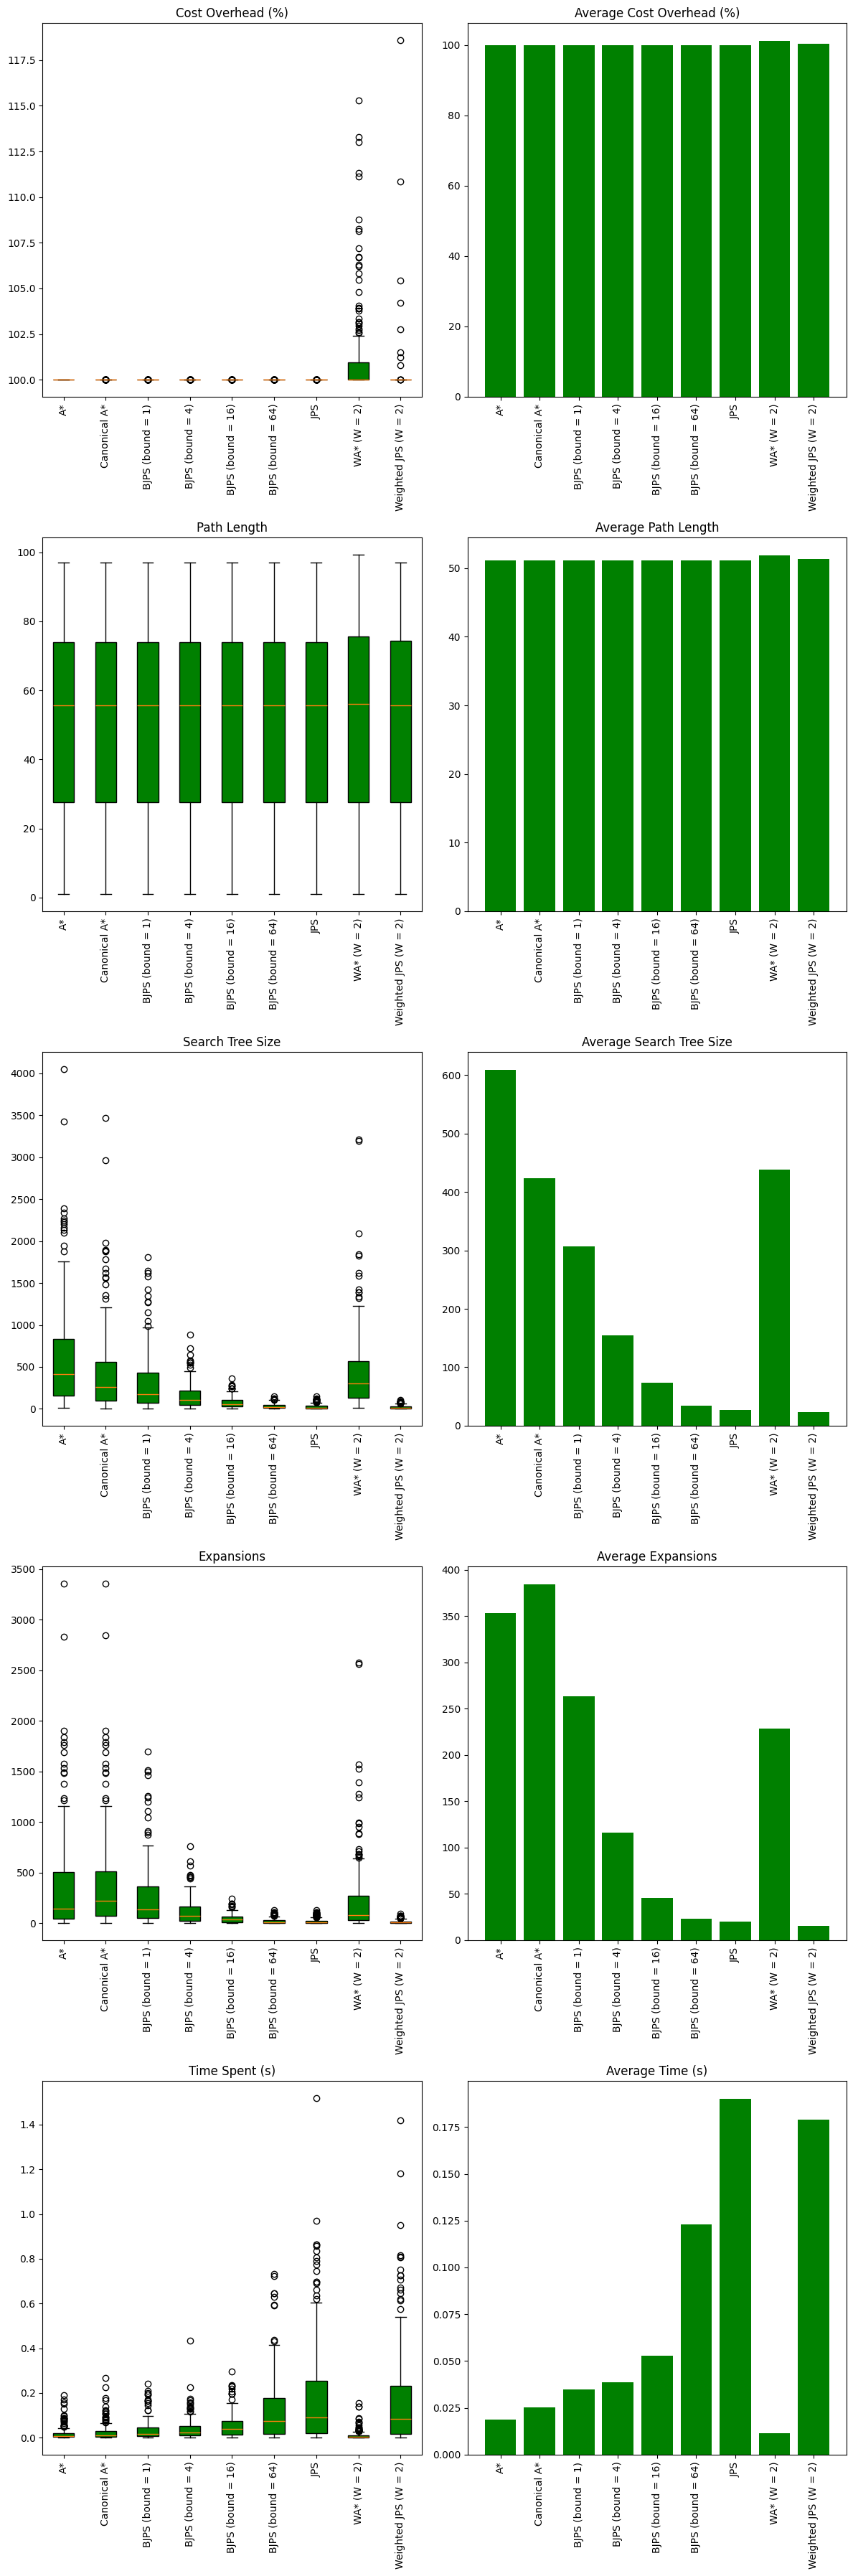

Running tests on Medium tasks, 100 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average cost overhead: ===
A*: 100%
Canonical A*: 100%
BJPS (bound = 1): 100%
BJPS (bound = 4): 100%
BJPS (bound = 16): 100%
BJPS (bound = 64): 100%
JPS: 100%
WA* (W = 2): 102%
Weighted JPS (W = 2): 100%
=== Average path length: ===
A*: 278.359616
Canonical A*: 278.359616
BJPS (bound = 1): 278.359616
BJPS (bound = 4): 278.359616
BJPS (bound = 16): 278.359616
BJPS (bound = 64): 278.359616
JPS: 278.359616
WA* (W = 2): 284.398850
Weighted JPS (W = 2): 279.066824
=== Average search tree size: ===
A*: 10837
Canonical A*: 9577
BJPS (bound = 1): 7264
BJPS (bound = 4): 2834
BJPS (bound = 16): 1073
BJPS (bound = 64): 385
JPS: 253
WA* (W = 2): 7095
Weighted JPS (W = 2): 181
=== Average expansions: ===
A*: 9390
Canonical A*: 9449
BJPS (bound = 1): 7087
BJPS (bound = 4): 2686
BJPS (bound = 16): 949
BJPS (bound = 64): 334

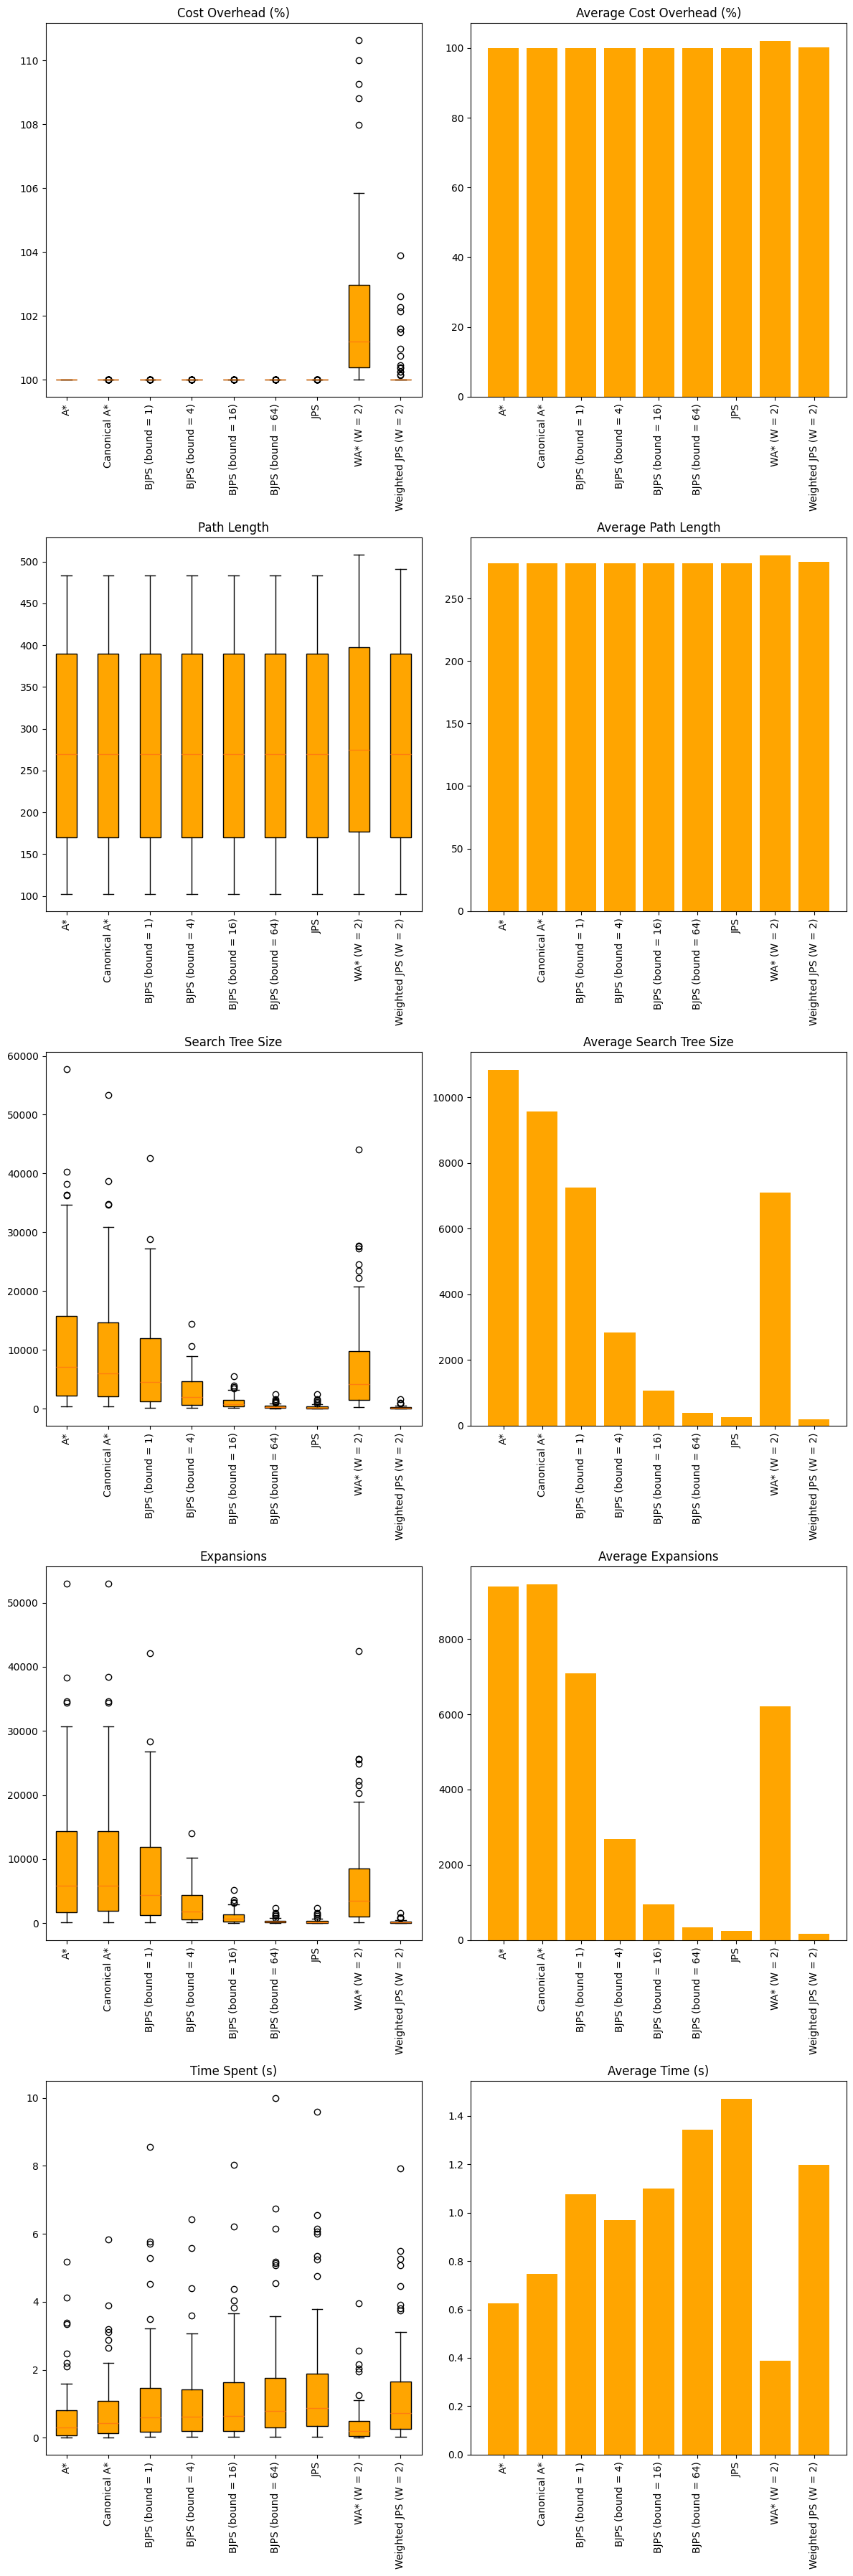

Running tests on Hard tasks, 30 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average cost overhead: ===
A*: 100%
Canonical A*: 100%
BJPS (bound = 1): 100%
BJPS (bound = 4): 100%
BJPS (bound = 16): 100%
BJPS (bound = 64): 100%
JPS: 100%
WA* (W = 2): 102%
Weighted JPS (W = 2): 100%
=== Average path length: ===
A*: 957.942510
Canonical A*: 957.942510
BJPS (bound = 1): 957.942510
BJPS (bound = 4): 957.942510
BJPS (bound = 16): 957.942510
BJPS (bound = 64): 957.942510
JPS: 957.942510
WA* (W = 2): 978.073289
Weighted JPS (W = 2): 961.045454
=== Average search tree size: ===
A*: 64559
Canonical A*: 62825
BJPS (bound = 1): 50747
BJPS (bound = 4): 18987
BJPS (bound = 16): 7085
BJPS (bound = 64): 2525
JPS: 1879
WA* (W = 2): 49474
Weighted JPS (W = 2): 1291
=== Average expansions: ===
A*: 62611
Canonical A*: 62630
BJPS (bound = 1): 50458
BJPS (bound = 4): 18751
BJPS (bound = 16): 6886
BJPS (bound =

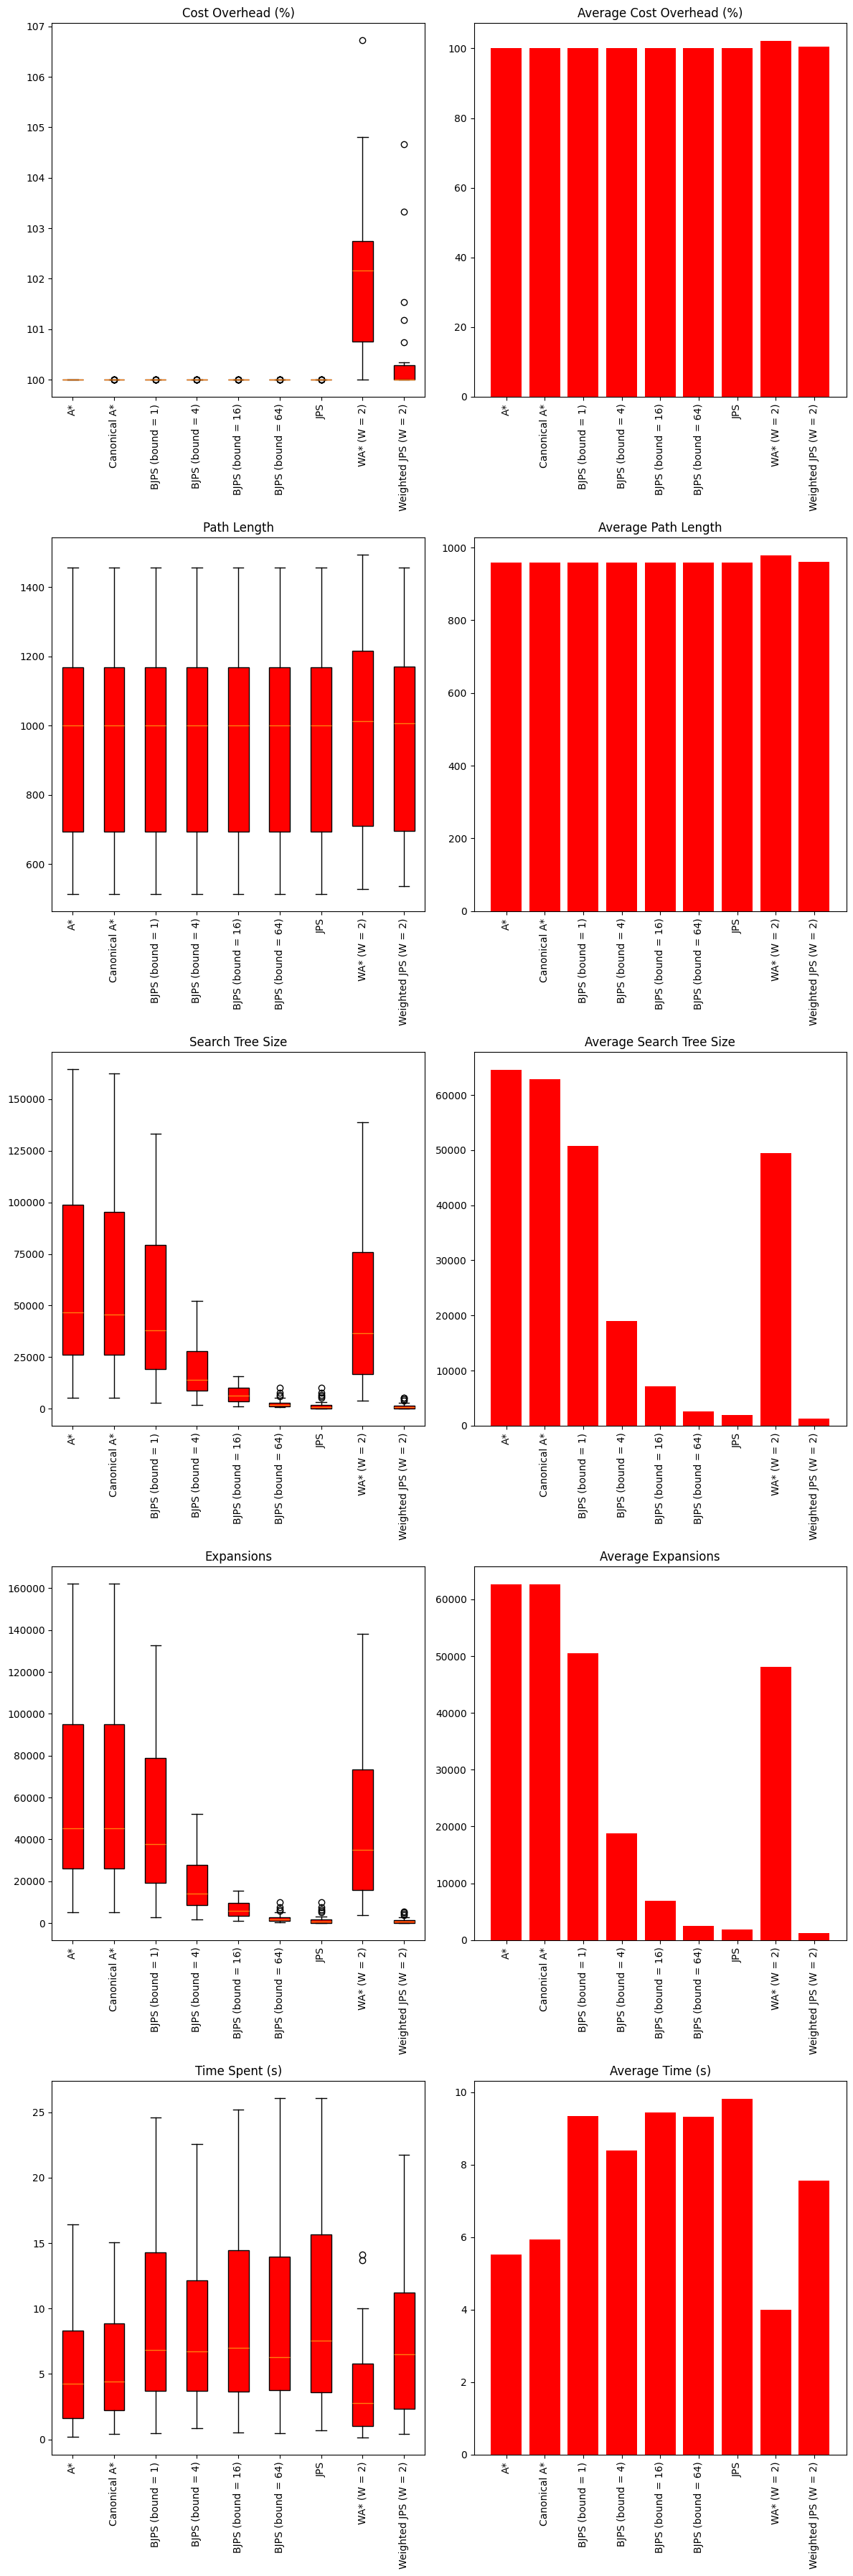

Running tests on Brutal tasks, 10 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average cost overhead: ===
A*: 100%
Canonical A*: 100%
BJPS (bound = 1): 100%
BJPS (bound = 4): 100%
BJPS (bound = 16): 100%
BJPS (bound = 64): 100%
JPS: 100%
WA* (W = 2): 101%
Weighted JPS (W = 2): 100%
=== Average path length: ===
A*: 2770.478411
Canonical A*: 2770.478411
BJPS (bound = 1): 2770.478411
BJPS (bound = 4): 2770.478411
BJPS (bound = 16): 2770.478411
BJPS (bound = 64): 2770.478411
JPS: 2770.478411
WA* (W = 2): 2810.988497
Weighted JPS (W = 2): 2777.567141
=== Average search tree size: ===
A*: 122603
Canonical A*: 122272
BJPS (bound = 1): 93196
BJPS (bound = 4): 41825
BJPS (bound = 16): 19383
BJPS (bound = 64): 15151
JPS: 14968
WA* (W = 2): 110899
Weighted JPS (W = 2): 12459
=== Average expansions: ===
A*: 122169
Canonical A*: 122172
BJPS (bound = 1): 93079
BJPS (bound = 4): 41732
BJPS (bound = 16)

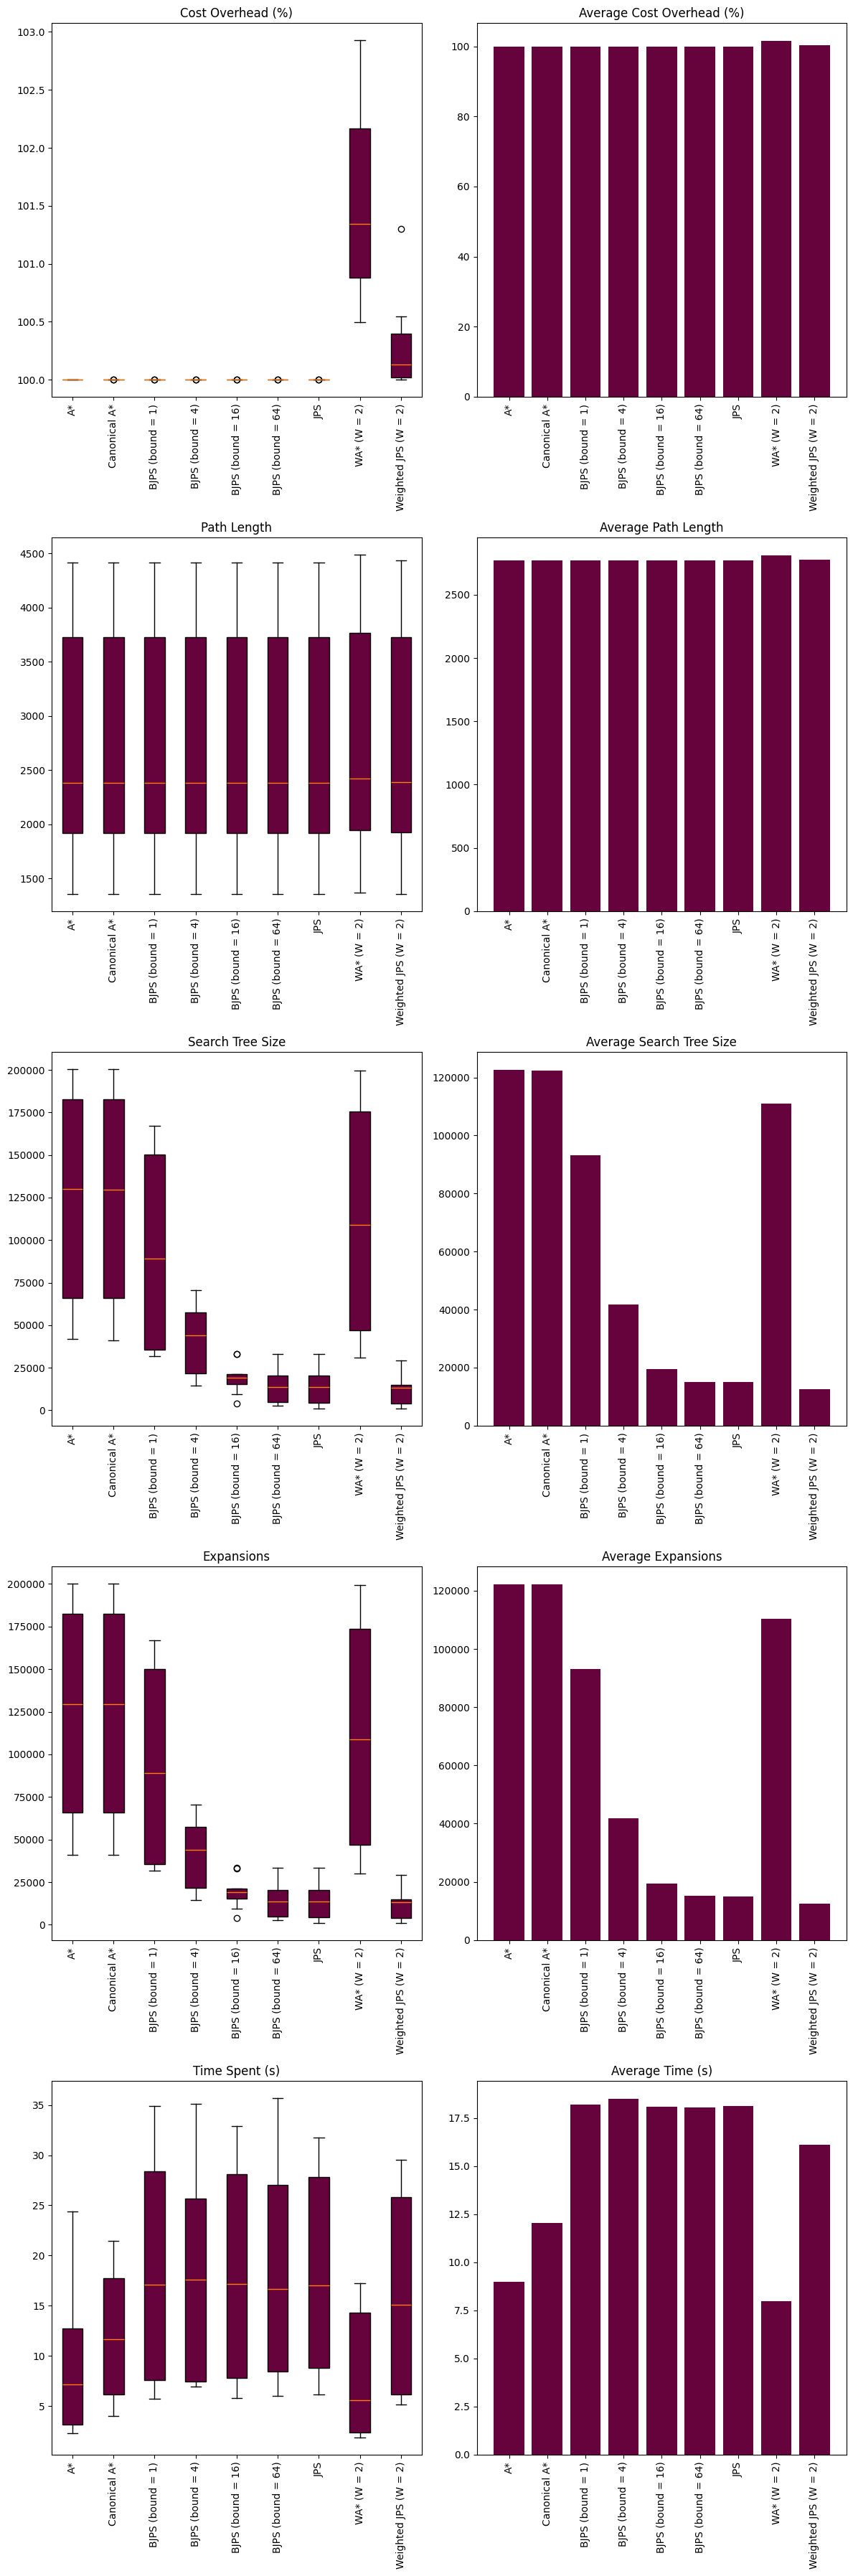

In [33]:
rand = random.Random(192840)

maze_scenarios = [
    'maze512-1-0.map.scen',
    'maze512-2-8.map.scen',
    'maze512-4-8.map.scen',
    'maze512-8-8.map.scen',
    'maze512-16-2.map.scen',
    'maze512-32-0.map.scen',
    'maze512-32-9.map.scen',
]

test_on_scenarios(maze_scenarios)

### 9.5. Карты-комнаты

In [ ]:
rand = random.Random(192841)

room_scenarios = [
    '8room_000.map.scen',
    '16room_008.map.scen',
    '32room_000.map.scen',
    '64room_003.map.scen',
]

test_on_scenarios(room_scenarios)

### 9.6. Карты Dragon Age: Origins

In [ ]:
rand = random.Random(192842)

da_scenarios = [
    'AR0011SR.map',
    'AR0014SR.map',
    'AR0044SR.map',
    'AR0046SR.map',
    'AR0070SR.map',
    'AR0071SR.map',
    'AR0072SR.map',
    'AR0202SR.map',
    'AR0205SR.map',
    'AR0300SR.map',
    'AR0307SR.map',
    'AR0400SR.map',
    'AR0406SR.map',
    'AR0411SR.map',
    'AR0600SR.map',
    'AR0700SR.map',
    'AR0701SR.map'
]

test_on_scenarios(da_scenarios)

### 9.7. Карты Baldur's Gate

In [ ]:
rand = random.Random(192843)

bg_scenarios = [
    'arena2.map.scen',
    'brc202d.map.scen',
    'brc204d.map.scen',
    'brc501d.map.scen',
    'brc504d.map.scen',
    'combat.map.scen',
    'den504d.map.scen',
    'den602d.map.scen',
    'den900d.map.scen',
    'isound1.map.scen',
    'lak304d.map.scen',
    'lak405d.map.scen',
    'lak512d.map.scen',
    'orz103d.map.scen',
    'orz700d.map.scen',
    'orz702d.map.scen',
    'orz900d.map.scen',
    'ost004d.map.scen',
    'ost100d.map.scen'
]

test_on_scenarios(bg_scenarios)